# Initializing

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import comet_ml
import os
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from src.utils.coco import COCODataset
from src.utils.pretty_print import *
from src.models import get_model_maskrcnn
from src.utils.train import maskrcnn_training_testing_loop
from src.utils.comet import CometLogger
from dotenv import load_dotenv

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42

# for reproducibility
torch.manual_seed(SEED)

# Datasets

## COCO Datasets

In [6]:
slide_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/slides/l8/annotations.json")

In [15]:
import albumentations as A

transform = A.Compose([
    #A.HorizontalFlip(0.5),
    #A.VerticalFlip(0.5),
    A.ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))


/storage01/bolma/dev/tumor-region-detection-thesis/.venv/lib/python3.10/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [16]:
train_dataset = COCODataset(
    annotation_file=slide_path,
    train=True,
    transform=None,
    random_seed=SEED,
    split_file=Path("dataset_split.json"),
    bbox_format='pascal_voc'
)

test_dataset = COCODataset(
    annotation_file=slide_path,
    train=False,
    transform=None,
    random_seed=SEED,
    split_file=Path("dataset_split.json"),
    bbox_format='pascal_voc'
)

# Checks
train_images = set(id for id in train_dataset.image_ids)
test_images = set(id for id in test_dataset.image_ids)

print(f"Training image id-s: \t{train_images}")
print(f"\nTest image id-s: \t{test_images}")

# Overlapping images between datasets
overlapping_images = train_images.intersection(test_images)

if overlapping_images:
    print("\n[WARNING]: Overlapping images found:")
    for img in overlapping_images:
        print(f"- {img}")
else:
    print_success("Datasets are properly split and ready to use!")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded split from dataset_split.json

✅ Found 38 training images and 10 test images

✅ Loaded training set with 38 images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded split from dataset_split.json

✅ Found 38 training images and 10 test images

✅ Loaded test set with 10 images

Training image id-s: 	{0, 1, 2, 3, 4, 6, 7, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 47}

Test image id-s: 	{5, 37, 8, 9, 12, 46, 24, 25, 27, 30}

✅ Datasets are properly split and ready to use!


### Visualization

Training Dataset Examples:
Image index: 16 (Image ID: 20)


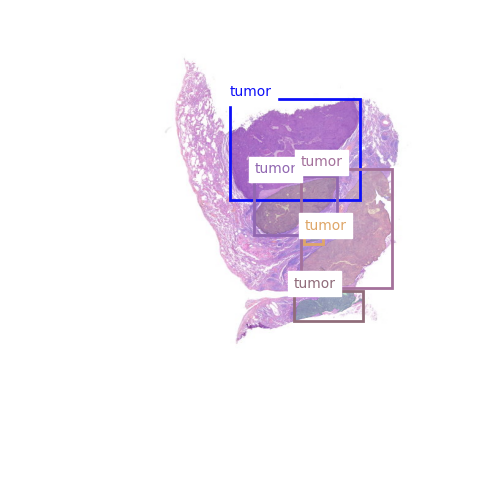

Image index: 22 (Image ID: 29)


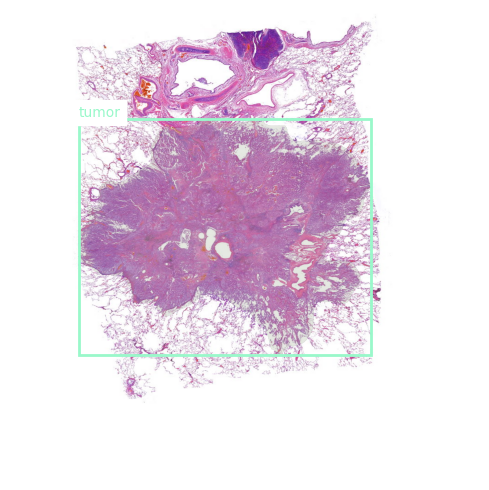

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from matplotlib.patches import Rectangle

def visualize_coco_samples(dataset, num_samples=3, indices=None, figsize=(15, 5), 
                          show_masks=True, show_boxes=True, show_labels=True,
                          mask_alpha=0.3, random_color=True):
    """
    Visualizes samples from COCO dataset with annotations.
    """
    if indices is None:
        # Get random indices
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        print(f"Image index: {idx} (Image ID: {dataset.image_ids[idx]})")
        image, target = dataset[idx]
        
        # If image is a tensor, convert to numpy array for visualization
        if isinstance(image, torch.Tensor):
            img = image.cpu().numpy().transpose(1, 2, 0)
            # Use consistent scaling - divide by 255 instead of min-max normalization
            img = img / 255.0
            # Clip to valid range
            img = np.clip(img, 0, 1)
        else:
            img = np.array(image) / 255.0
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=figsize)
        
        # Display image
        ax.imshow(img)
        
        # Get masks, boxes, and labels from target
        masks = target['masks']
        boxes = target['boxes']
        labels = target['labels']
        
        # Create a single combined overlay for all masks
        if show_masks and len(masks) > 0:
            # Initialize combined overlay
            h, w = masks[0].shape if len(masks) > 0 else img.shape[:2]
            combined_overlay = np.zeros((h, w, 4))  # RGBA image for overlay
            
            for i in range(len(masks)):
                if i < len(masks):
                    # Generate color for this instance
                    if random_color:
                        color = np.random.rand(3)
                    else:
                        cmap = plt.cm.get_cmap('tab10')
                        color = cmap(labels[i] % 10)[:3]
                    
                    # Add this mask to the combined overlay
                    mask = masks[i].cpu().numpy()
                    combined_overlay[mask == 1, :3] = color
                    combined_overlay[mask == 1, 3] = mask_alpha  # Set alpha channel
            
            # Apply the combined overlay
            ax.imshow(combined_overlay)
        
        # Display bounding boxes and labels
        for i in range(len(boxes)):
            # Generate color for this instance
            if random_color:
                color = np.random.rand(3)
            else:
                cmap = plt.cm.get_cmap('tab10')
                color = cmap(labels[i] % 10)[:3]
            
            # Display bounding box if requested
            if show_boxes and i < len(boxes):
                box = boxes[i].cpu().numpy()
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                rect = Rectangle((x1, y1), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Display category label if requested
                if show_labels:
                    category_id = labels[i].item()
                    category_name = dataset.categories.get(category_id, str(category_id))
                    ax.text(x1, y1-5, category_name, color=color, 
                           fontsize=10, backgroundcolor='white')
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

print("Training Dataset Examples:")
visualize_coco_samples(train_dataset, num_samples=2)

## Dataloaders

In [18]:
BATCH_SIZE = 1
NUM_WORKERS = 8

In [19]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))  # To handle variable size images/masks
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))
)

print_info(f"Created DataLoaders with batch size {BATCH_SIZE}")
print(f"\t- Training batches: {len(train_dataloader)}")
print(f"\t- Test batches: {len(test_dataloader)}")


ℹ️ Created DataLoaders with batch size 1
	- Training batches: 38
	- Test batches: 10


# Training

## Model architecture

In [20]:
from src.models import get_model_maskrcnn_with_groupnorm

maskrcnn = get_model_maskrcnn_with_groupnorm(num_classes=2, 
                      box_score_thresh=0.1,
                      box_nms_thresh=0.3,
                      box_fg_iou_thresh=0.5,
                      box_bg_iou_thresh=0.4,
                      box_detections_per_img=10,
                      image_mean = [0.485, 0.456, 0.406],
                      image_std = [0.229, 0.224, 0.225])

optimizer = torch.optim.SGD(maskrcnn.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

## Training loop

In [21]:
import warnings

# For logging to comet.ml, a cloud service
load_dotenv()
api_key = os.getenv('COMET_API_KEY')
comet_logger = CometLogger(api_key=api_key,
                        project_name="msc-thesis",
                        experiment_name="MaskRCNN-valid-noaug",
                        log_env_details=False,)

# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    # Training loop
    maskrcnn_training_testing_loop(maskrcnn,device, train_dataloader, test_dataloader, optimizer, scheduler, n_epochs=30, box_score_thresh=0.5, comet_logger=comet_logger)


# Save some sample images with predictions to comet.ml
with torch.set_grad_enabled(False):
    comet_logger.upload_images(
        model = maskrcnn,
        device = device,
        dataloader = test_dataloader,
        confidence_thr = 0.5,
        entry_name = "sample_img",
        overwrite = True,
        indices = [0,1,2],
    )

comet_logger.end() # End the comet logger session

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/bolf-marton/msc-thesis/393d827f7be749ab9544f1912bdddd50




🚀 STARTING TRAINING
---------------------------------
Epoch 1/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:04<00:00,  7.81it/s]


Train – Mean Loss: 2.1394


100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Test – IoU: 0.3064, Loss: 1.5549
---------------------------------
Epoch 2/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:04<00:00,  9.00it/s]


Train – Mean Loss: 1.7583


100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Test – IoU: 0.3150, Loss: 1.2978
---------------------------------
Epoch 3/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.01it/s]


Train – Mean Loss: 1.5043


100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Test – IoU: 0.3480, Loss: 1.3196
---------------------------------
Epoch 4/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.21it/s]


Train – Mean Loss: 1.4374


100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Test – IoU: 0.4350, Loss: 1.5372
---------------------------------
Epoch 5/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:05<00:00,  7.42it/s]


Train – Mean Loss: 1.4340


100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Test – IoU: 0.4103, Loss: 1.4307
---------------------------------
Epoch 6/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.24it/s]


Train – Mean Loss: 1.4135


100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


Test – IoU: 0.4489, Loss: 1.3149
---------------------------------
Epoch 7/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:05<00:00,  6.97it/s]


Train – Mean Loss: 1.3615


100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Test – IoU: 0.4745, Loss: 1.5261
---------------------------------
Epoch 8/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:05<00:00,  7.57it/s]


Train – Mean Loss: 1.2857


100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Test – IoU: 0.4160, Loss: 1.2630
---------------------------------
Epoch 9/30 - MaskRCNN-valid-noaug
---------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.46it/s]


Train – Mean Loss: 1.2879


100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


Test – IoU: 0.4498, Loss: 1.4412
----------------------------------
Epoch 10/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  7.83it/s]


Train – Mean Loss: 1.3053


100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


Test – IoU: 0.4353, Loss: 1.5518
----------------------------------
Epoch 11/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.07it/s]


Train – Mean Loss: 1.2398


100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Test – IoU: 0.4551, Loss: 1.5130
----------------------------------
Epoch 12/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:05<00:00,  7.46it/s]


Train – Mean Loss: 1.2239


100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Test – IoU: 0.5310, Loss: 1.4227
----------------------------------
Epoch 13/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.22it/s]


Train – Mean Loss: 1.1841


100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Test – IoU: 0.4459, Loss: 1.3791
----------------------------------
Epoch 14/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.13it/s]


Train – Mean Loss: 1.2080


100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Test – IoU: 0.4587, Loss: 1.5615
----------------------------------
Epoch 15/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.01it/s]


Train – Mean Loss: 1.1739


100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


Test – IoU: 0.4177, Loss: 1.4428
----------------------------------
Epoch 16/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:05<00:00,  7.36it/s]


Train – Mean Loss: 1.1711


100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Test – IoU: 0.4482, Loss: 1.5684
----------------------------------
Epoch 17/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.12it/s]


Train – Mean Loss: 1.1741


100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Test – IoU: 0.3906, Loss: 1.3203
----------------------------------
Epoch 18/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  9.35it/s]


Train – Mean Loss: 1.1443


100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Test – IoU: 0.4867, Loss: 1.9274
----------------------------------
Epoch 19/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  7.85it/s]


Train – Mean Loss: 1.1777


100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Test – IoU: 0.4883, Loss: 1.6775
----------------------------------
Epoch 20/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  7.71it/s]


Train – Mean Loss: 1.1144


100%|██████████| 10/10 [00:01<00:00,  8.51it/s]


Test – IoU: 0.4594, Loss: 1.5502
----------------------------------
Epoch 21/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  7.80it/s]


Train – Mean Loss: 1.1502


100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Test – IoU: 0.4127, Loss: 1.8595
----------------------------------
Epoch 22/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  7.87it/s]


Train – Mean Loss: 1.1404


100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Test – IoU: 0.4692, Loss: 1.5479
----------------------------------
Epoch 23/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  7.93it/s]


Train – Mean Loss: 1.1260


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Test – IoU: 0.4126, Loss: 1.5363
----------------------------------
Epoch 24/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.31it/s]


Train – Mean Loss: 1.0602


100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Test – IoU: 0.4701, Loss: 1.8073
----------------------------------
Epoch 25/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.32it/s]


Train – Mean Loss: 1.0200


100%|██████████| 10/10 [00:01<00:00,  8.51it/s]


Test – IoU: 0.4759, Loss: 1.8411
----------------------------------
Epoch 26/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.48it/s]


Train – Mean Loss: 1.0124


100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Test – IoU: 0.4773, Loss: 1.8093
----------------------------------
Epoch 27/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:05<00:00,  7.50it/s]


Train – Mean Loss: 1.0032


100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Test – IoU: 0.4514, Loss: 1.8188
----------------------------------
Epoch 28/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  9.12it/s]


Train – Mean Loss: 0.9809


100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Test – IoU: 0.4378, Loss: 1.8829
----------------------------------
Epoch 29/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:04<00:00,  8.33it/s]


Train – Mean Loss: 0.9862


100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Test – IoU: 0.4541, Loss: 1.8031
----------------------------------
Epoch 30/30 - MaskRCNN-valid-noaug
----------------------------------


100%|██████████| 38/38 [00:05<00:00,  7.31it/s]


Train – Mean Loss: 0.9847


100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


Test – IoU: 0.4539, Loss: 1.7823


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : MaskRCNN-valid-noaug
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/393d827f7be749ab9544f1912bdddd50
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou [30]           : (0.30637304584900116, 0.53101328106188)
COMET INFO:     learning_rate [30] : (0.001, 0.01)
COMET INFO:     loss [114]         : (0.4290936291217804, 3.135662317276001)
COMET INFO:     test_loss [30]     : (1.2629655599594116, 1.9273903369903564)
COMET INFO:     training_loss [30] : (0.9808976054191589, 2.1394028663635254)
COMET INFO:   Others:
COMET INFO:     Name : MaskRCNN-valid-noaug
COMET INFO:   Uploads:
COMET INFO:     filename  

In [22]:
# Save the model weights
torch.save(maskrcnn.state_dict(), "src/models/weights/MaskRCNN_trained_weights_eval.pth")